In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.table import Table

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
tab = Table.read('3dhst_master.phot.v4.1.csv', format='ascii').to_pandas()

## Preprocessing

In [ ]:
tab = tab[tab.lmass > 9].copy()

target = 'z_spec'  # spectroscopic redshift
#features = [col for col in tab.columns if (col != target)]

tab['f_F125W_f_F140W'] = tab['f_F125W'] - tab['f_F140W']
tab['f_F125W_f_F160W'] = tab['f_F125W'] - tab['f_F160W']
tab['f_F125W_f_F606W'] = tab['f_F125W'] - tab['f_F606W']
tab['f_F125W_f_F814W'] = tab['f_F125W'] - tab['f_F814W']

tab['f_F140W_f_F160W'] = tab['f_F140W'] - tab['f_F160W']
tab['f_F140W_f_F606W'] = tab['f_F140W'] - tab['f_F606W']
tab['f_F140W_f_F814W'] = tab['f_F140W'] - tab['f_F814W']

tab['f_F160W_f_F606W'] = tab['f_F160W'] - tab['f_F606W']
tab['f_F160W_f_F814W'] = tab['f_F160W'] - tab['f_F814W']

tab['f_F606W_f_F814W'] = tab['f_F606W'] - tab['f_F814W']
features = [col for col in tab.columns if (col != target and col[0:3] == 'f_F' and col[-1] == 'W')]


features = [col for col in features if (col != 'Av') and (col != 'lmass') and (col != 'z_peak') 
            and (col != 'flags') and (col != 'f140w_flag') and (col != 'star_flag') 
            and (col != 'use_phot') and (col != 'near_star')]

tab = tab[(tab[target] > 0)].copy()

label_encoder = LabelEncoder()
tab['field'] = label_encoder.fit_transform(tab['field'])

errors = [col for col in features if (col[:1] == 'e') and (col[-1:] == 'W')]

for error in errors:
    tab[error] = np.where(tab[error] < -90, tab[error].median(), tab[error])

### Train test split

In [4]:
X = tab[features].values
y = tab[target].values

indices = np.arange(len(y))

# first reserve 70% of the data for training, 30% for validation
X_train, X_validate, y_train, y_validate, indices_train, indices_validate = train_test_split(X, y, indices, test_size=0.3, random_state=42)

# second, split the validation set in half to obtain validation and test sets. 
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(X_validate, y_validate, indices_validate, test_size=0.5, random_state=42)

### Model

In [ ]:
param_grid = {
    'n_estimators': [800, 900, 1000, 1100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9]
}

gbr = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_estimators': 900}


In [6]:
gbr = grid_search.best_estimator_
y_predict = gbr.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

MSE = 0.1257


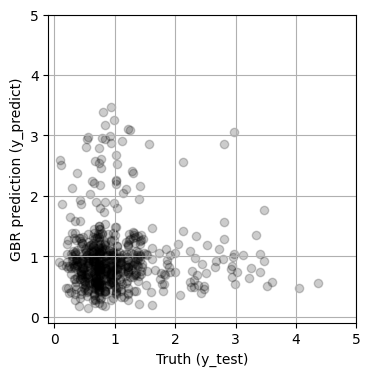

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_validate, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('GBR prediction (y_predict)')
plt.show()

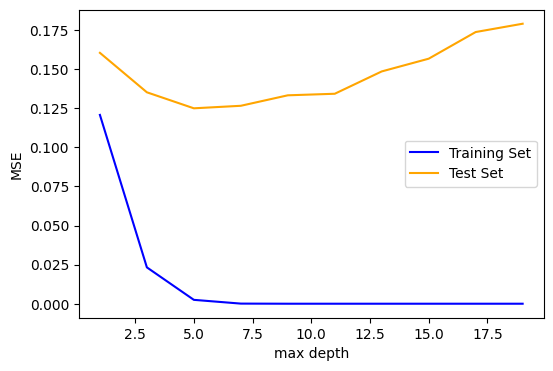

In [8]:
max_depths = np.arange(1, 20, 2).astype(int)

train_mse = []
test_mse = []
for depth in max_depths:
    params = {
        "n_estimators": 1000,
        "learning_rate": 0.05,
        "max_depth": depth,
    }
    gbrf = GradientBoostingRegressor(**params)
    gbrf.fit(X_train, y_train)

    y_predict_train = gbrf.predict(X_train)
    y_predict_test = gbrf.predict(X_test)

    train_mse.append(mean_squared_error(y_train, y_predict_train))
    test_mse.append(mean_squared_error(y_test, y_predict_test))
    
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(max_depths, train_mse, color='blue', label='Training Set')
ax.plot(max_depths, test_mse, color='orange', label='Test Set')
ax.set_xlabel('max depth')
ax.set_ylabel('MSE')
ax.legend()

plt.show()

In [9]:
cv = cross_validate(
    estimator=gbr, 
    X=X,
    y=y, 
    cv=5,
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.163 +/- 0.058


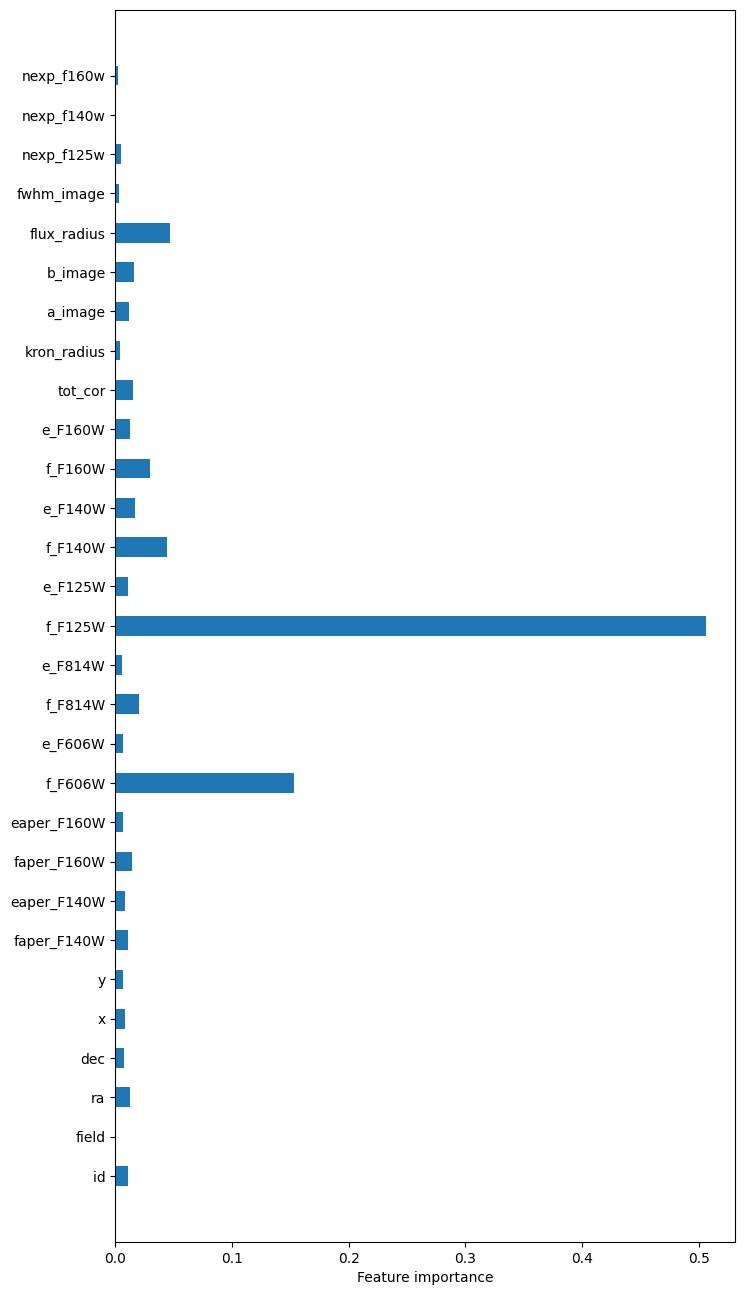

In [10]:
importances = gbr.feature_importances_

fig = plt.figure(0, [8, 16])
ax = fig.add_subplot(111)
ax.barh(np.arange(X.shape[1]), importances, 
        align='center', 
        height=0.5, 
        tick_label=features)
ax.set_xlabel("Feature importance")

plt.show()

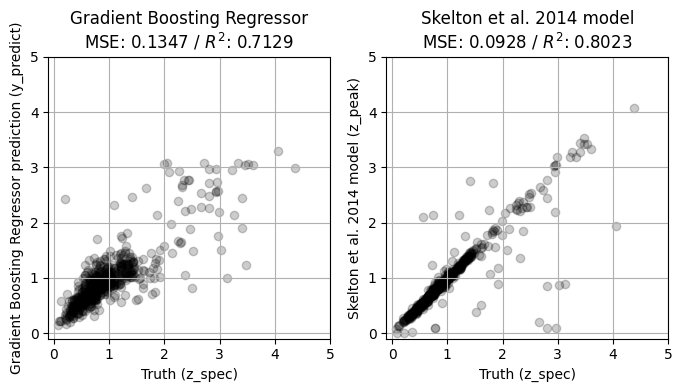

In [11]:
y_predict_validate = gbr.predict(X_validate)
y_skelton2014 = tab['z_peak'].values[indices_validate]

mse_gbr = mean_squared_error(y_validate, y_predict_validate)
r2_gbr = r2_score(y_validate, y_predict_validate)

mse_skelton = mean_squared_error(y_validate, y_skelton2014)
r2_skelton = r2_score(y_validate, y_skelton2014)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(y_validate, y_predict_validate, alpha=0.2, color='black')
ax[0].set_aspect('equal')
ax[0].set_xlim(-0.1, 5)
ax[0].set_ylim(-0.1, 5)
ax[0].grid()
ax[0].set_xlabel('Truth (z_spec)')
ax[0].set_ylabel('Gradient Boosting Regressor prediction (y_predict)')
ax[0].set_title(f'Gradient Boosting Regressor\nMSE: {mse_gbr:.4f} / $R^2$: {r2_gbr:.4f}')


ax[1].scatter(y_validate, y_skelton2014, alpha=0.2, color='black')
ax[1].set_aspect('equal')
ax[1].set_xlim(-0.1, 5)
ax[1].set_ylim(-0.1, 5)
ax[1].grid()
ax[1].set_xlabel('Truth (z_spec)')
ax[1].set_ylabel('Skelton et al. 2014 model (z_peak)')
ax[1].set_title(f'Skelton et al. 2014 model\nMSE: {mse_skelton:.4f} / $R^2$: {r2_skelton:.4f}')

plt.show()